In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import utils
import torchvision
from torchvision import transforms
import time
import pickle as pkl
import csv
import numpy as np
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from matplotlib import pyplot as plt
from PIL import Image
import json

In [2]:
from tqdm import tqdm, tqdm_notebook
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import numpy as np
from pycocotools.coco import COCO

In [3]:
from data_loader import *

import vocabulary_struct
import AnnoNet
#import AnnoNetRNN as AnnoNet

## Load Pre-Trained Model

In [4]:
model_path = "best_model_base3.pt"       # load best model

train_loss_path = "train_loss_base3"     # load training loss and val loss for plotting
val_loss_path = "val_losses_base3"

prediction = 's'  # change to 'd' for deterministic
temp = 0.2        # 0.2 yields best results

true_annotations_file ='./data/annotations/captions_val2014.json' 
pred_annotations_file = 'stoch_0_2_model_captions.json'     # name of json file to save all captions

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
with open('Vocab_File', 'rb') as f:
    vocab = pkl.load(f)

with open('TestImageIds.csv', 'r') as f:
    reader = csv.reader(f)
    testIds = list(reader)

testIds = [int(i) for i in testIds[0]]

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        #torch.nn.init.xavier_uniform_(m.bias.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs     = 100
batch_size = 128
criterion = torch.nn.CrossEntropyLoss()
AnnoNet = AnnoNet.AnnoNet(vocab_size = len(vocab), batch_size = batch_size, embedding_dim=256,hidden_dim = 512, hidden_units=1)
AnnoNet.apply(init_weights)
AnnoNet.load_state_dict(torch.load(model_path))
AnnoNet.eval()

AnnoNet.to(device)

AnnoNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 2

In [8]:
test_coco = CocoDataset(root='./data/images/test/',
                       json='./data/annotations/captions_val2014.json',
                       ids = testIds,
                       vocab=vocab,
                       transform=None)

loading annotations into memory...
Done (t=0.38s)
creating index...
index created!


In [9]:
transform = transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize((0.485, 0.456, 0.406), 
                             (0.229, 0.224, 0.225))])

def prep_image(image, transform=None):
    image = image.resize([250, 250], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [10]:
def evaluate_captions( true_captions_path, generated_captions_path ):
    """
    Takes json formatted true and predicted captions, and calculates BLEU1, BLEU4 scores
    :param true_captions_path: path to json file with true COCO captions, used with pycocotools.coco
    :param generated_captions_path: path to json file with predicted COCO captions, used with pycocotools.coco
    
    :return: BLEU1, BLEU2 score tuple
    """
    
    
    coco = COCO(true_captions_path)
    cocoRes = COCO(generated_captions_path)
    
    with open(generated_captions_path) as f:
        yours = json.load(f)    
    
    
    score1 = 0
    score4 = 0

    smoother = SmoothingFunction()
    
    print('\n')

    for i in tqdm([ a['image_id'] for a in yours['annotations']]):
        candidate = cocoRes.imgToAnns[i][0]['caption']
        print('imageID: ', i)
        print('candidate: ', candidate)
        
        
        reference = []
        for entry in coco.imgToAnns[i]:
            reference.append(entry['caption'])
            
        print('reference: ', reference, "\n")


        score1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0), smoothing_function=smoother.method1)
        score4 += sentence_bleu(reference, candidate, weights=(0, 0, 0, 1), smoothing_function=smoother.method1)

    bleu1 = 100*score1/len([ a['image_id'] for a in yours['annotations']])
    bleu4 = 100*score4/len([ a['image_id'] for a in yours['annotations']])

        
    print("BLEU 1:", np.round(bleu1,2), 
          "BLEU 4:", np.round(bleu4,2))
    
    return bleu1, bleu4

## Create json file of Captions

In [ ]:
data={}
data['annotations'] = []

ID=0
coco = COCO(true_annotations_file)
'''
for my_id in range(len(testIds)):
    img_id = test_coco.ids[my_id]
    test_im, test_tar = test_coco.__getitem__(my_id)
'''
for imageID in testIds:
    
    #print('imgID: ', imageID)
    path = coco.loadImgs(imageID)[0]['file_name']

    string='data/images/test/'

    newpath= string+path

    test_im = Image.open(os.path.join(newpath)).convert('RGB')
    print("My ID: ", ID)
    print("COCO ID: ", imageID)
    new_test_im = prep_image(test_im, transform)
    new_test_im = new_test_im.to(device)
    #print(new_test_im)
    new_test_output = AnnoNet.eval_pass(new_test_im, prediction=prediction, temp=temp)
    my_out = new_test_output[0].cpu()

    out_sentence = []
    for i in my_out:
        #print(i)
        word = vocab.index2word[int(i)]
        out_sentence.append(word)

    str_sentence = ' '.join(out_sentence) 
    if out_sentence[0] == '<start>':
        str_sentence=str_sentence.split(' ', 1)[1]
    if out_sentence[-1] == '<end>':
        str_sentence=str_sentence.rsplit(' ', 1)[0]
        if out_sentence[-2] == '.':
            str_sentence=str_sentence.rsplit(' ', 1)[0]
            str_sentence=str_sentence+'.'
    
    print(str_sentence)
    
    out_obj = {}
    out_obj['image_id'] = imageID
    out_obj['id'] = ID
    out_obj['caption'] = str_sentence

    data['annotations'].append(out_obj)
    
    ID += 1
    
    #print(data)
    
    
    #convert data into a json
    with open(pred_annotations_file, 'w') as outfile:
        json.dump(data, outfile)

In [11]:
BLEU1, BLEU4 = evaluate_captions( true_annotations_file, pred_annotations_file )

loading annotations into memory...


 11%|█         | 31/290 [00:00<00:00, 309.74it/s]

Done (t=0.40s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


imageID:  549907
candidate:  an elephant is walking in the water near a river.
reference:  ['an elephant playing with water at a watering hole with his trunk', "An elephant's front legs are in the water and back legs are out of the water.", 'an elephant is going to the river to drink water', 'An elephant standing with its front feet in the water.', 'An elephant stands with its front feet in shallow water. '] 

imageID:  209613
candidate:  a herd of sheep grazing on a lush green hillside.
reference:  ['Three look alike dogs are herding sheep into a pile.', 'Small group of sheep being herded by three border collies.', 'These sheep are being watched by three dogs.', 'A group of sheep in a field with three dogs close by.', 'A group of sheep surrounded by three dogs.'] 

imageID:  351975
candidate:  a laptop computer sitting on top of a desk.
reference:  ['An 

 36%|███▌      | 104/290 [00:00<00:00, 333.46it/s]

candidate:  a couple of zebras are standing in the wild.
reference:  ['A zebra standing at the edge of a pond.', 'a zebra that is standing by some water', 'A zebra stands in the shade while looking into a puddle of water.', 'there is a zebra that is standing by the water', 'a lone zebra stands just before a small body of water and looks down'] 

imageID:  466239
candidate:  a train traveling down tracks near a bridge.
reference:  ['An Amtrak train traveling under a train bridge.', 'A train on the tracks under a bridge.', 'A passenger train crossing over a railroad bridge on a cloudy day.', 'A railroad train traveling through an  overpass ', 'A train travels underneath a very old bridge.'] 

imageID:  134863
candidate:  a traffic light on a street corner with a clock on the side of the road.
reference:  ['A couple of traffic lights hanging over a city street.', 'Traffic lights shine over an empty intersection at twilight. ', 'A street with traffic lights, wall and buildings.', 'The elec

 55%|█████▍    | 159/290 [00:00<00:00, 288.53it/s]

81512
candidate:  a large window with a clock on it.
reference:  [' A display case filled with lots of different vases.', 'This a collection of flowered vases and kettles. ', 'A china cabinet filled with fine blue and pink china. ', 'A number of decorated vases in a glass shelf', 'A bunch of glass vases that are in a glass case.'] 

imageID:  564355
candidate:  a person on skis standing in the snow.
reference:  ['a man is out in the snow with skis', 'A person with some skis in the snow.', 'A man not wearing a coat is skiing. ', 'A man on snow skis with a short sleeve shirt on.', 'a person riding skis on a snowy surface'] 

imageID:  181179
candidate:  a kitchen with a stove and a sink
reference:  ['Meat left out on the kitchen counter could spoil.', 'Chopped meat laid out on towels in a home kitchen, in preparation for cooking.', 'a counter top with food sitting on some towels', 'Meats being prepared for cooking on kitchen counter.', 'A bunch of uncooked food on a counter.'] 

imageID:

 76%|███████▌  | 219/290 [00:00<00:00, 289.32it/s]

a herd of elephants walking across a dirt field.
reference:  ['Three elephants in sandy area next to trees.', 'Three large elephants and one small elephant stand in an enclosure with lots of bushes.', 'Three large elephants are strolling beside a small younger one.', 'four elephants in captivity with trees near by', 'An elephant family standing in the stand at a zoo.'] 

imageID:  154830
candidate:  a person riding a bicycle on a street.
reference:  ['Car waits as person on bike crosses the road', 'A four lane street in the suburbs ', 'A bicyclist crossing the street as a car waits to turn.', 'A man with a backpack riding a bicycle by a traffic light.', 'A full view of a suburban city with people. '] 

imageID:  138124
candidate:  a bathroom with a sink and a sink
reference:  ['A bathroom has a light above the toilet.', 'A white toilet sitting in a bathroom next to a bath tub.', 'a photograph of a bathroom with a blue wall', 'The bathroom is clean and crisp with a blue wall. ', "A smal

100%|██████████| 290/290 [00:00<00:00, 295.19it/s]


candidate:  a train traveling down tracks next to a train.
reference:  ['Locomotive pulling cars on tracks in outdoor area.', 'A train on the tracks with smoke coming out the top.', 'A train sitting on top of train tracks near  forest.', 'A train travelling on a track passing two white gates while smoke is coming from it. ', 'An old fashioned steam engine with cars attached.'] 

imageID:  201120
candidate:  a person is sitting on a bench with a skateboard.
reference:  ['A table topped with pieces of cloth and large piece of paper.', 'A white piece of paper and a pair of scissors on top of colored pieces of fabric.', 'A piece of paper and some scissors on a table.', 'A table with a number of fabrics in different colors. ', 'A table displaying linens of assorted colors next to some scissors and paper.'] 

imageID:  70426
candidate:  a woman in a bikini riding a surfboard on a beach.
reference:  ['Adult woman with yellow surfboard standing in water.', 'A woman in the ocean holding a surf

## Plot Loss Curves

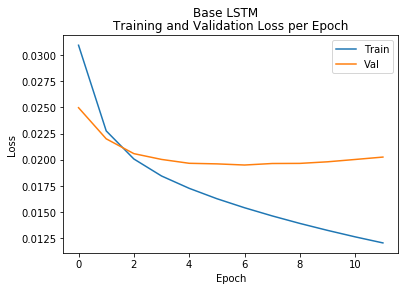

In [12]:
train_loss = torch.load(train_loss_path)
val_loss = torch.load(val_loss_path)

line1, = plt.plot(range(len(train_loss)), train_loss)
line2, = plt.plot(range(len(val_loss)), val_loss)
plt.suptitle("Base LSTM")
plt.title("Training and Validation Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend([line1, line2], ['Train', 'Val'])